In [15]:
import pandas as pd
import numpy as np
from pyproj import Proj
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [19]:
#str_name = '2014-01 - Citi Bike trip data.csv'
str_name2 = '2014-02 - Citi Bike trip data.csv'

#data1 = read_data(str_name)
data = read_data(str_name2)
#data = pd.concat([data1,data2],axis=0,ignore_index=True)
print(data.info())

def get_projXY(idx,data):
    # calculate projected coordinates of input data
    data_num = len(idx)
    CoordsX1 = []
    CoordsY1 = []
#     CoordsX2 = []
#     CoordsY2 = []
    point = Proj(init='epsg:32118')
    for i in range(data_num):
        x1,y1 = point(data['start station longitude'][idx[i]],data['start station latitude'][idx[i]])
#         x2,y2 = point(data['end station longitude'][idx[i]],data['end station latitude'][idx[i]])
        CoordsX1.append(x1)
        CoordsY1.append(y1)
#         CoordsX2.append(x2)
#         CoordsY2.append(y2)
    return CoordsX1,CoordsY1#,CoordsX2,CoordsY2
def set_episode(d):
    d['episode'][d['starttime'].dt.hour<11]=0
    d['episode'][((d['starttime'].dt.hour>=11) & (d['starttime'].dt.hour<12))|((d['starttime'].dt.hour>=16) & (d['starttime'].dt.hour<17))] = 1
    d['episode'][(d['starttime'].dt.hour>=12) & (d['starttime'].dt.hour<16)] = 2
    d['episode'][(d['starttime'].dt.hour>=17) & (d['starttime'].dt.hour<18)] =3
    d['episode'][d['starttime'].dt.hour>=18] = 4
    return d
def read_data(str):
    data = pd.read_csv(str)
    data = data.drop(['usertype','birth year','gender'],axis=1)
    # project data
    x1,y1= get_projXY(data.index,data)
    data['x1'] = x1
    data['y1'] = y1
    data['starttime'] = pd.to_datetime(data['starttime'],format='%Y-%m-%d %H:%M:%S')
    #data['stoptime'] = pd.to_datetime(data['stoptime'],format='%Y-%m-%d %H:%M:%S')
    data['start timestamp'] = (data['starttime']-pd.to_datetime('2013-07-01 00:00:00')).dt.total_seconds()
    data_time_filter = data[(data['starttime'].dt.hour<23)&(data['starttime'].dt.hour>=7)]
    # set episode
    data_time_filter['episode']=np.zeros(len(data_time_filter))
    data_time_filter = set_episode(data_time_filter)
    # set time index
    #data_time_filter.index = data_time_filter['starttime']
    # set cluster
    data_time_filter['cluster']=np.zeros(len(data_time_filter))
    return data_time_filter

<class 'pandas.core.frame.DataFrame'>
Int64Index: 210754 entries, 582 to 224606
Data columns (total 17 columns):
tripduration               210754 non-null int64
starttime                  210754 non-null datetime64[ns]
stoptime                   210754 non-null object
start station id           210754 non-null int64
start station name         210754 non-null object
start station latitude     210754 non-null float64
start station longitude    210754 non-null float64
end station id             210754 non-null int64
end station name           210754 non-null object
end station latitude       210754 non-null float64
end station longitude      210754 non-null float64
bikeid                     210754 non-null int64
x1                         210754 non-null float64
y1                         210754 non-null float64
start timestamp            210754 non-null float64
episode                    210754 non-null float64
cluster                    210754 non-null float64
dtypes: datetime64[ns](1

In [17]:
print(data.shape)

(210754, 17)


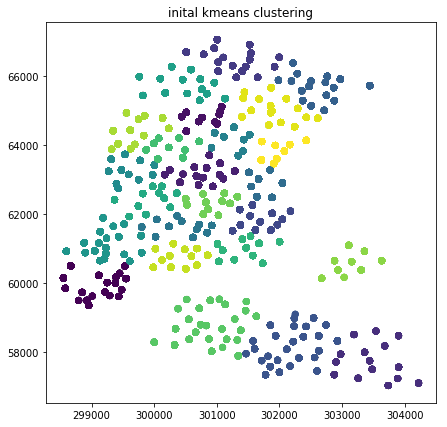

0
0
0
0
0
0
0
0
0
0


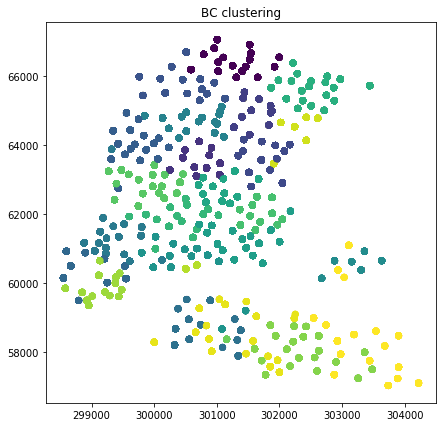

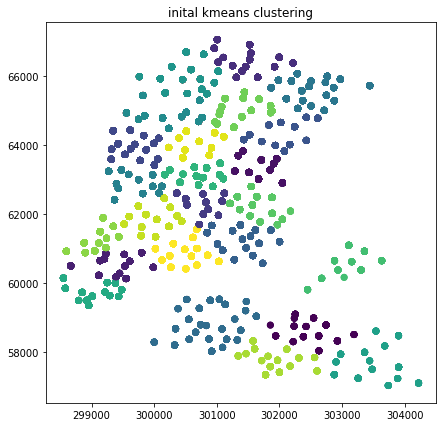

0
0
0
0
0
0
0
0
0
0


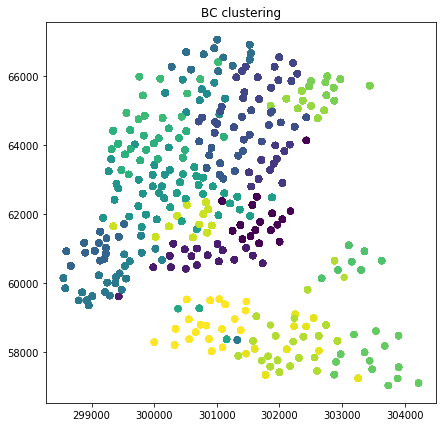

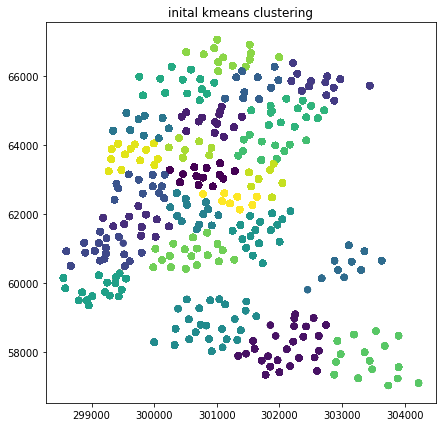

0
0
0
0
0
0
0
0
0
0


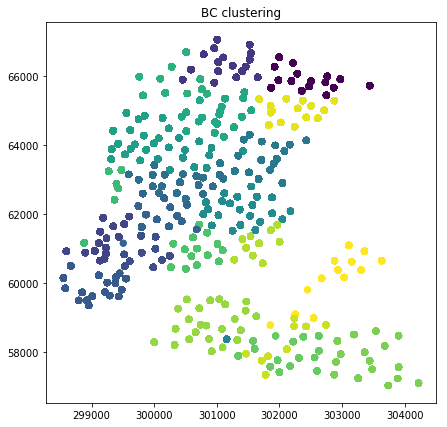

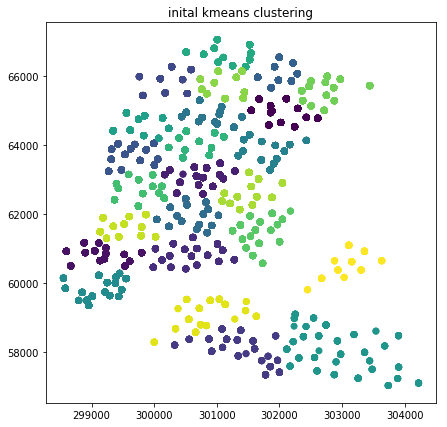

0
0
0
0
0
0
0
0
0
0


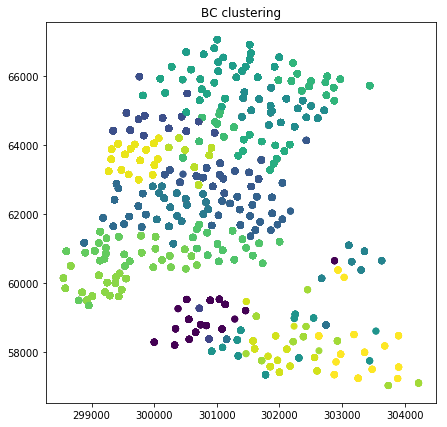

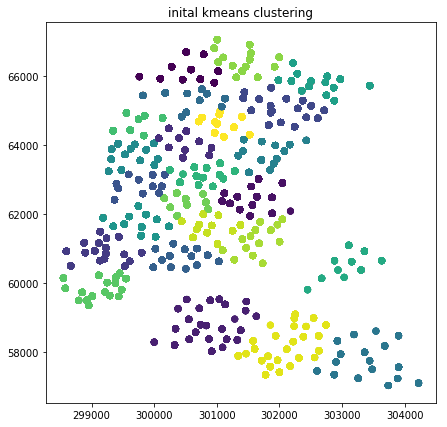

0
0
0
0
0
0
0
0
0
0


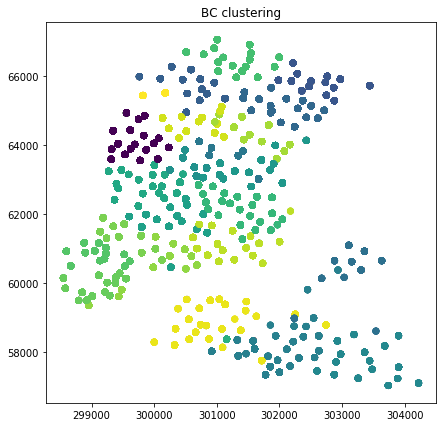

In [18]:
# clustering
def Kcluster(K,X):
    kmeans = KMeans(n_clusters=K).fit(X)
    label_ = kmeans.labels_
    centers_ = kmeans.cluster_centers_
    return label_,centers_
# cal transition matrix based on clusters
def get_transition_matrix(station,data):
    clusters = pd.unique(data['cluster'])
    clusters_num = len(clusters)
    trans_mx = np.zeros((len(station),clusters_num))
    for i in range(len(station)):
        s_ = station[i]
        e_ = data['end station id'][data['start station id']==s_]
        for ii in range(len(e_)):
            cluster0 = pd.unique(data['cluster'][data['start station id']==e_.iloc[ii]])    
            #print(len(cluster0))
            cluster0_num = len(cluster0)
            for j in range(cluster0_num):
                trans_mx[i][clusters==cluster0[j]] +=1
        num_sum = np.sum(trans_mx[i])
        trans_mx[i] = trans_mx[i]/num_sum
    #print(trans_mx)
    return trans_mx
# # get unique station id
# station_start = pd.unique(data['start station id'])
# station = pd.unique(station_start)
# print(station)
K1 = 24
K = 5
K2 = 8
# initial cluster
# Kmeans clustering
for i in range(5):
    # inital kmeans clustering
    X = np.array(data[['x1', 'y1']][data['episode']==i])
    labels, centers = Kcluster(K1,X)
    data['cluster'][data['episode']==i]=labels
    plt.figure(figsize=(7,7))
    plt.scatter(data['x1'][data['episode']==i],data['y1'][data['episode']==i],c=data['cluster'][data['episode']==i])
    plt.title('inital kmeans clustering')
    plt.savefig('kmeans'+str(i)+'.png',dpi=600,bbox_inches='tight')
    plt.show()
    # biparate clustering
    for j in range(K):
        # initialize 
        # get station for period
        station = pd.unique(data['start station id'][data['episode']==i])
        # cal every station's transition
        trans_mx = get_transition_matrix(station,data[data['episode']==i])
        # cal every station cluster
        station_labels = KMeans(n_clusters=K2).fit(trans_mx).labels_
        print(len(station_labels)-len(station))
        for ii in range(len(station)):
            data['cluster'][(data['start station id']==station[ii])&(data['episode']==i)]=station_labels[ii]
        cl_ = pd.unique(data['cluster'][data['episode']==i])
        print(len(cl_)-len(pd.unique(station_labels)))
        offset = 0
        #ss_num = 0
        for ii in range(len(cl_)):
            X_ = np.array(data[['x1','y1']][(data['episode']==i)&(data['cluster']==cl_[ii])])
            s_num = pd.unique(data['start station id'][(data['episode']==i)&(data['cluster']==cl_[ii])])
            #print(s_num)
            n_c = int(np.round(len(s_num)*K1/len(station)))
            #ss_num += len(s_num)
            #print(n_c)
            labels2, centers2 = Kcluster(n_c,X_)
            #print(len(labels2)-len(station))
            labels2 = labels2 +offset
            data['cluster'][(data['episode']==i)&(data['cluster']==cl_[ii])]=labels2
            offset +=n_c   
        #print(len(station)-ss_num)
    plt.figure(figsize=(7,7))
    plt.scatter(data['x1'][data['episode']==i],data['y1'][data['episode']==i],c=data['cluster'][data['episode']==i])
    plt.title('BC clustering')
    plt.savefig('bc'+str(i)+'.png',dpi=600,bbox_inches='tight')
    plt.show()

In [7]:
def generate_region(data):
    ep_datas = []
    for p in range(5):
        ep_data = data[data['episode']==p]
  
        station_data = ep_data[['start station id', 'cluster', 'x1', 'y1']].drop_duplicates()
        
        station_mapping = {i: c for i, c in station_data[['start station id', 'cluster']].values}
        #print(station_mapping)
        ep_data = ep_data[ep_data['end station id'].isin(ep_data['start station id'])] # remove the usless end station
        ep_data['start id'] = ep_data['start station id'].replace(station_mapping)
        ep_data['end id'] = ep_data['end station id'].replace(station_mapping)

        ep_data = ep_data[ep_data['start id']!=ep_data['end id']]
        #print('episode', p, (ep_data['start id']==ep_data['end id']).describe())
        
        geo_info = station_data.groupby('cluster').mean()[['x1', 'y1']].reset_index(level=0)
        geo_info.columns = ['start id', 'rx1', 'ry1']
        ep_data = pd.merge(ep_data, geo_info, how='left')
        
        ep_datas.append(ep_data)
    return pd.concat(ep_datas)
region = generate_region(data)
print(region.info())

# print((region['start id'] == region['end id']).describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 171667 entries, 0 to 46441
Data columns (total 21 columns):
tripduration               171667 non-null int64
starttime                  171667 non-null datetime64[ns]
stoptime                   171667 non-null object
start station id           171667 non-null int64
start station name         171667 non-null object
start station latitude     171667 non-null float64
start station longitude    171667 non-null float64
end station id             171667 non-null int64
end station name           171667 non-null object
end station latitude       171667 non-null float64
end station longitude      171667 non-null float64
bikeid                     171667 non-null int64
x1                         171667 non-null float64
y1                         171667 non-null float64
start timestamp            171667 non-null float64
episode                    171667 non-null float64
cluster                    171667 non-null float64
start id                   

(24, 24)
[1 1 2 1 1 1 0 0 2 2 0 1 0 1 0 1 1 1 0 2 0 0 2 2]
24


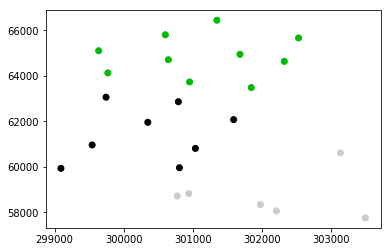

(24, 24)
[1 0 0 1 0 0 1 1 0 0 2 2 2 0 0 0 0 2 2 1 2 1 0 1]
24


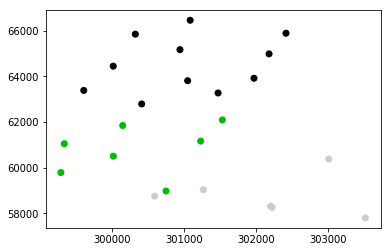

(23, 23)
[0 2 0 0 0 2 0 0 0 2 0 1 0 0 0 1 2 1 1 0 1 1 2]
23


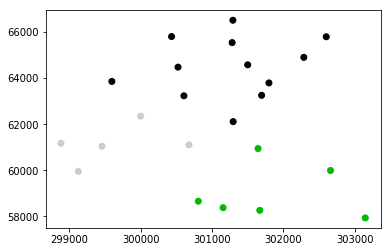

(25, 25)
[2 0 1 0 1 0 0 1 1 1 0 0 1 0 0 0 0 1 1 2 0 2 2 2 2]
25


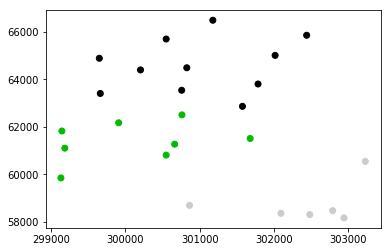

(24, 24)
[0 2 0 0 1 0 0 2 0 0 0 0 2 0 0 0 2 0 1 2 1 1 2 1]
24


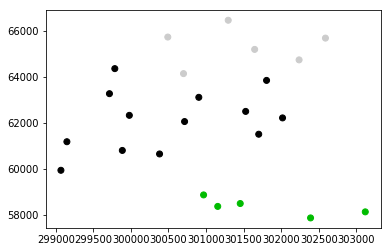

In [9]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph
# cal community
def get_transition_region(data):
    # get region transititon
    # find all unique region
    regions = pd.unique(data['start id'])
    region_num = len(regions)
#     print(regions)
#     print(len(regions))
    # initialize a transition matrix
    trans_mx = np.zeros((region_num,region_num))
    #print(trans_mx)
    # foor loop every region
    for i in range(region_num):
        s_ = regions[i]
        e_ = data['end id'][data['start id']==s_]
        #print(e_)
        # foor loop every end region
        for ii in range(len(e_)): 
            trans_mx[i][np.array(regions)==e_.iloc[ii]] +=1
        num_sum = np.sum(trans_mx[i])
        trans_mx[i] = trans_mx[i]/num_sum
    #print(trans_mx)
    return trans_mx

# 
region['community'] = np.zeros(len(region))
  
def generate_community(region):
    for i in range(5):
        n_clusters = [3,3,3,3,3]
        p_region = region[region['episode']==i]
        uni_region = p_region['start id']
    #     print(region.shape)
        region_trans = get_transition_region(p_region)
        print(region_trans.shape)
        A = kneighbors_graph(region_trans,5, mode='connectivity', include_self=True)
    #     print(A)
    #     print(A.toarray())
        rxy_ = p_region[['start id','rx1','ry1']].drop_duplicates()
        rxy = np.array(rxy_[['rx1','ry1']])
    #     print(np.array(rxy))
    #     print(region_unX)
        model = AgglomerativeClustering(connectivity=A,n_clusters=n_clusters[i],compute_full_tree=1)
        model.fit(rxy)
        rxy_['labels']=model.labels_
        print(model.labels_)
        print(model.n_leaves_)
        # save file
        for j in range(len(rxy)):
            p_region['community'][p_region['start id']==rxy_['start id'].iloc[j]] = rxy_['labels'].iloc[j]
        #print(p_region['community'])
        region['community'][region['episode']==i] = p_region['community']
        plt.figure()
        plt.scatter(rxy[:, 0], rxy[:, 1], c=model.labels_,
                            cmap=plt.cm.nipy_spectral)
        plt.show()
    return region

region_ = generate_community(region)
region_ = region_.drop(['start station name','start station latitude','start station longitude',
                       'end station name','end station latitude','end station longitude',
                       'bikeid'],axis=1)
# region_.to_csv('Final-'+str_name,header=True,index=False)

In [14]:
def show_inter_independence(df):
    epdf = df
    communities = epdf['community'].unique()
    c = len(communities)
    mat = np.zeros([c]*2)
    for ci in range(c):
        for cj in range(c):
            mat[ci, cj] = len(epdf[(epdf['community'] == ci) &
                               (epdf['end community'] == cj)])
    #print('Episode {}'.format(episode))
    print(mat)
def community_clean(data):
    ep_datas = []
    for p in range(5):
        ep_data = data[data['episode']==p]
        ep_data = ep_data[ep_data['end id'].isin(ep_data['start id'])] # remove the usless end region
        region_mapping = {i: c for i, c in ep_data[['start id', 'community']].values}
        ep_data['end community'] = ep_data['end id'].replace(region_mapping)
        l1 = len(ep_data)
        ep_data = ep_data[ep_data['community'] == ep_data['end community']]
        l2 = len(ep_data)
        #print(l1)
        print(l1-l2)
        ep_datas.append(ep_data)
    return pd.concat(ep_datas)
t = community_clean(region_)
t.drop(['end community'],axis=1)
#t.to_csv('Final-'+str_name+str_name2,header=True,index=False)


11480
6429
14652
5194
14784


,tripduration,starttime,stoptime,start station id,end station id,x1,y1,start timestamp,episode,cluster,start id,end id,rx1,ry1,community
0,382,2014-02-01 07:00:46,2014-02-01 07:07:08,492,153,300765.905371,64799.044431,18601246.0,0.0,11.0,11.0,19.0,300645.123775,64705.968021,1.0
1,236,2014-02-01 07:01:42,2014-02-01 07:05:38,482,496,300057.619812,63594.735150,18601302.0,0.0,10.0,10.0,9.0,299768.812643,64127.357644,1.0
2,427,2014-02-01 07:01:54,2014-02-01 07:09:01,258,310,302632.684724,58048.576085,18601314.0,0.0,15.0,15.0,29.0,302206.764365,58059.679926,2.0
3,316,2014-02-01 07:02:45,2014-02-01 07:08:01,476,379,301717.851152,64104.394011,18601365.0,0.0,12.0,12.0,11.0,301843.186071,63482.388703,1.0
4,330,2014-02-01 07:04:43,2014-02-01 07:10:13,523,525,300727.796717,65294.979728,18601483.0,0.0,8.0,8.0,18.0,300600.674663,65802.772260,1.0
5,690,2014-02-01 07:05:29,2014-02-01 07:16:59,478,352,300097.761694,65920.710119,18601529.0,0.0,8.0,8.0,5.0,300600.674663,65802.772260,1.0
6,620,2014-02-01 07:06:09,2014-02-01 07:16:29,281,477,302219.370062,66375.914218,18601569.0,0.0,23.0,23.0,8.0,302527.233730,65661.331950,1.0
8,629,2014-02-01 07:08:44,2014-02-01 07:19:13,317,383,301533.031078,61949.369645,18601724.0,0.0,22.0,22.0,24.0,301588.765661,62074.009178,0.0
9,330,2014-02-01 07:09:05,2014-02-01 07:14:35,521,458,300438.259743,64826.784379,18601745.0,0.0,11.0,11.0,10.0,300645.123775,64705.968021,1.0
10,554,2014-02-01 07:10:34,2014-02-01 07:19:48,487,402,302049.423970,62905.093496,18601834.0,0.0,12.0,12.0,9.0,301843.186071,63482.388703,1.0
